# Implement name classifier
1. With `GPU`
2. With `data parallel`
3. Use `pad-pack`

In [1]:
import typing
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from utils import *

torch.manual_seed(1249583)

# See the details in `Dataset` section
SEQUENCE_LENGTH = 19
COUNTRY_LENGTH = 18

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [57]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = make_var(data)        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        tmp = output.view(-1, COUNTRY_LENGTH)
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = make_var(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            tmp = output.view(-1, COUNTRY_LENGTH)
            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=test_loader.dataset.countries, normalize=True,
                          title='Confusion matrix')


In [157]:
class TwoLayers(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Another stack
        self.rrelu = nn.LeakyReLU()
        self.gru2 = nn.GRU(output_size, output_size, 1)
        self.fc2 = nn.Linear(output_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        lengths = count_non_zero_length(input)
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input).to(self.device)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        
        pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths)
        packed_output, hidden = self.gru(pps_in, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # This line is no need. Because I use `hidden` as an output
        # result, pps_out_size = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc output: {fc_output.size()}")
        
        # Add one more stack
        hidden2 = self._init_hidden2(batch_size)
        result = self.rrelu(fc_output)
        result, hidden_2 = self.gru2(fc_output, hidden2)
        result = self.fc2(hidden_2)
        return result
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(DEVICE)
    
    def _init_hidden2(self, batch_size):
        return torch.zeros(1, batch_size, COUNTRY_LENGTH)

In [163]:
# classifier = RNNClassifier()
# classifier = ModelX(n_layers=2)
classifier = TwoLayers()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")



in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [164]:
names = ['adylov', 'solan', 'hard', 'san']
# classifier = RNNClassifier()
# classifier = ModelX()
classifier = TwoLayers()
inputs = make_var(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 6]), 
batch out: torch.Size([1, 4, 18])


In [10]:
class ModelX(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1, dropout=0):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        lengths = count_non_zero_length(input)
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input).to(self.device)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        
        pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths)
        packed_output, hidden = self.gru(pps_in, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # This line is no need. Because I use `hidden` as an output
        # result, pps_out_size = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc aoutput: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(DEVICE)

In [32]:
# classifier = RNNClassifier()
classifier = ModelX()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")


in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [33]:
names = ['adylov', 'solan', 'hard', 'san']
# classifier = RNNClassifier()
classifier = ModelX()
inputs = make_var(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 6]), 
batch out: torch.Size([1, 4, 18])


In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        
        # Sung Kim run this all at once (over the whole input sequence)
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        
        # input: B x S -- (transpose) --> S x B
        input = input.t()
        
        # Embedding S x B -> S x B x I (embedding size)
        print(f" input size: {input.size()}")
        embedded = self.embedding(input)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        output, hidden = self.gru(embedded, hidden)
        print(f" gru hidden output: {hidden.size()}")
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        print(f" fc output: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(self.device)

# Dataset

In [4]:
class NameDataSet(Dataset):
    def __init__(self, filename='names_train.csv'):
        trainset = pd.read_csv(filename, header=None)
        trainset.columns = ['name', 'country']
        countries = sorted(list(trainset.country.drop_duplicates()))

        self.trainset = trainset
        self.countries = countries
        self.len = len(trainset)        

    def __getitem__(self, index):
        country = self.trainset.iloc[index]['country']
        return self.trainset.iloc[index]['name'], self.countries.index(country)

    def __len__(self):
        return self.len
        

In [5]:
train_dataset = NameDataSet(filename='../lessons/names_train.csv')
test_dataset = NameDataSet(filename='../lessons/names_test.csv')

In [6]:
%%time
train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=2, num_workers=2) # 2 * 9 * 743 
test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset), batch_size=2, num_workers=2) # 4 * 25 * 67


CPU times: user 9.05 s, sys: 0 ns, total: 9.05 s
Wall time: 9.06 s


# 1. TwoLayers

In [160]:
model = TwoLayers().to(DEVICE)

# 2. Criterion & Loss

In [161]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.795012
Train Epoch: 1 [2000/13374 (15%)]	Loss: 2.988508
Train Epoch: 1 [4000/13374 (30%)]	Loss: 2.492788
Train Epoch: 1 [6000/13374 (45%)]	Loss: 2.417980
Train Epoch: 1 [8000/13374 (60%)]	Loss: 2.608569
Train Epoch: 1 [10000/13374 (75%)]	Loss: 2.721196
Train Epoch: 1 [12000/13374 (90%)]	Loss: 1.481157



Test set: Average loss: 1.2966, Accuracy: 1601/6700 (24%)

[[125   3   5   9   0   4  15  37  30  17  35  23  11   8   9  33   7   3]
 [ 21  35   9  13   0   8  25  10  10  33  16 100   6  19   8  32   9  29]
 [ 17   9  39  14   0   9  35  13  23  23  39  22  32  16  27  25   8   9]
 [ 12   3   4 104   0  17  63  23  10  21  20  25  23  13  15  27   5   3]
 [ 21   5  10  25   2  25  45  18  31  20  15  29  16  13   9  67   4   6]
 [ 44   4   4  18   0  49  65  21  37  20  20  27   7   5   5  45   2   7]
 [ 26   3   6  37   0  25 125  19  18  14  17  15  22  12  12  14   2  10]
 [ 18   5   3  11   0  20  24 160  11   9  15  14   2  20   6   8   2   7]
 [ 30   6   7  19   0  18  18  12  88  28  27  21   8   9  10  56   8   2]
 [ 22   7   7   7   0  14  16   6  12 159  42  19   6  11   3  15  11   6]
 [ 21  21   5  14   0  12  26   9  18  30 155  26  12  11  11  14   5   4]
 [  7  22   8   9   0   8  16  14  16  32  12 105  12   6   8  37  11  30]
 [ 22   6  43  17   0   8  17  17  13  1

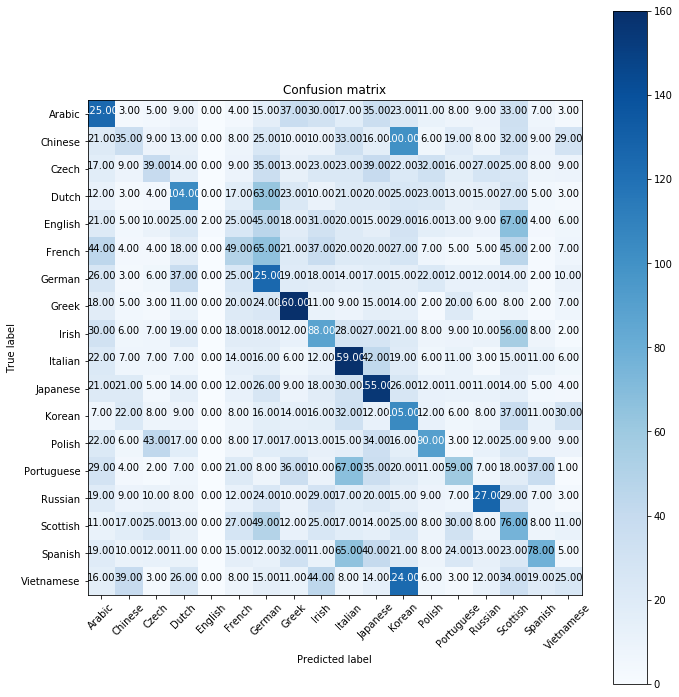

In [162]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

# 1. ModelX

In [54]:
model = ModelX().to(DEVICE)

# 2. Criterion & Loss

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.941617
Train Epoch: 1 [2000/13374 (15%)]	Loss: 2.903950
Train Epoch: 1 [4000/13374 (30%)]	Loss: 3.068733
Train Epoch: 1 [6000/13374 (45%)]	Loss: 1.339524
Train Epoch: 1 [8000/13374 (60%)]	Loss: 3.988051
Train Epoch: 1 [10000/13374 (75%)]	Loss: 4.155210
Train Epoch: 1 [12000/13374 (90%)]	Loss: 3.995715



Test set: Average loss: 1.3184, Accuracy: 1705/6700 (25%)

[[178   3   3  17   8   9  18  21  26  18  11  16   4   7   6   2   6   5]
 [ 26  60   5  24   6  21   6   6  33  33  33  47  11   7  12  11  16  26]
 [ 36   5  55  58  17  11  26   5  31  10  25  12  24   8  18  10  16  10]
 [ 21   2  10 121  15  13  33  10  25   8   4  12  14   5   7  20  18   7]
 [ 34  11   8  42  47  31  24   9  41  18  12  27  16   9   9  47  12   8]
 [ 30  10   9  14  40  78  34  11  38  17   8  22  14   4   7  10   6  16]
 [ 18  13  15  64  17   6  96   8  42  14  14  20  10   5  15  21   5   9]
 [ 45   8   0  37   4   8   7 133   9  11   7  11   6   6   7   8  20   2]
 [ 46   6   5  26  29   8  13   8 108  19  13  12   7   5  20  20   6   5]
 [ 18  10   8  15  10  20   5   6  22 152  16  11   4  11  12   8  36   6]
 [ 39   8   4  19   6  10   9   9  21  33 153  21  10  11   8  13   4   5]
 [ 24  40   4  18  12  21  11   6  19  28  12  84  13  15   6   6   7   8]
 [ 11   9  53  23  17  14  16  14  28  1

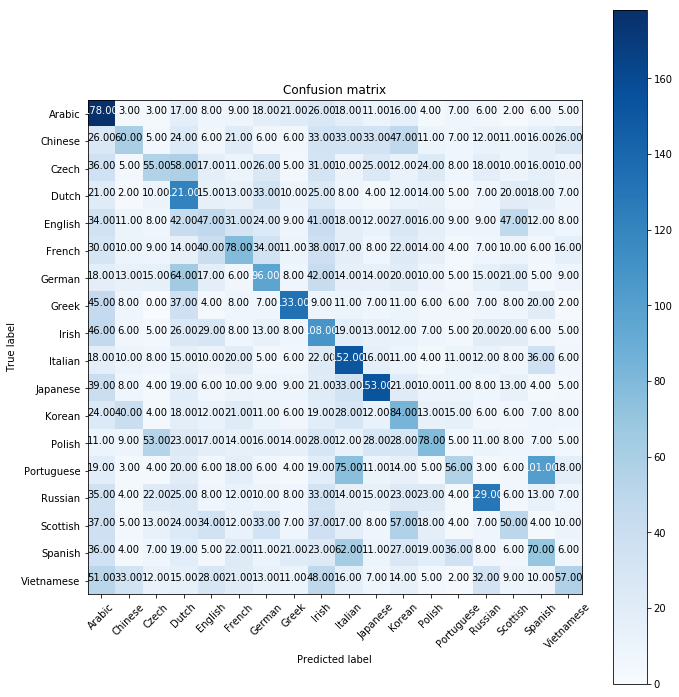

In [59]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

# Multipe layers

In [68]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = make_var(data)        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        local_tmp = output.view(-1, COUNTRY_LENGTH)
        tmp = local_tmp[train_loader.batch_size:]
        
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = make_var(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            local_tmp = output.view(-1, COUNTRY_LENGTH)
            tmp = local_tmp[test_loader.batch_size:]
            
            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=test_loader.dataset.countries, normalize=True,
                          title='Confusion matrix')


# 1. ModelY (ModelX with more than 1 layer)

In [69]:
model = ModelX(n_layers=2).to(DEVICE)

# 2. Criterion & Loss

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimier = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.889905
Train Epoch: 1 [2000/13374 (15%)]	Loss: 3.844368
Train Epoch: 1 [4000/13374 (30%)]	Loss: 2.275355
Train Epoch: 1 [6000/13374 (45%)]	Loss: 0.866237
Train Epoch: 1 [8000/13374 (60%)]	Loss: 2.672256
Train Epoch: 1 [10000/13374 (75%)]	Loss: 2.347872
Train Epoch: 1 [12000/13374 (90%)]	Loss: 1.875372



Test set: Average loss: 1.2956, Accuracy: 1789/6700 (27%)

[[134  11   8  11  16   7  25  26   6   6  68   8   4  10   6   6   2   4]
 [ 28 132  13   9   9   5  19  18   7  15  41  23   6  18  10  15   0  10]
 [ 12  15  63   7  19  13  31  22  12   6  79  17  23  13  19  15   6   1]
 [ 20  17  12  93  26   8  39  42  12   8  35   5   6  12  11  19  10   3]
 [ 19  18  15  15  67  27  32  36  31  15  34  11  10  12  10  27   2   8]
 [ 11  14  13   8  27  73  49  38  26  18  40  12   7   2  11  13   0  16]
 [ 10  15  14  40  24  11  96  29  11  11  26  13   4  11   9  14   1   5]
 [ 13  19   5   8  12   8  10 169   7   7  32   7  14  21   8   8   3   5]
 [ 19  17  13  17  28  10  23  29  73   4  54   6   5   9   6  21   3   6]
 [ 19  18  12   9   9  19  12  32  11  94  80   9   7  23   6  10   6   5]
 [  6  21   7  14   9  10   6  20   3   6 210  12  13  13   5   7   0   5]
 [ 16  63   9   4  11  10  10  16  19  13  23 100  15  19   6  16   4   3]
 [ 21  13  49  14   7   5  16  41  12   

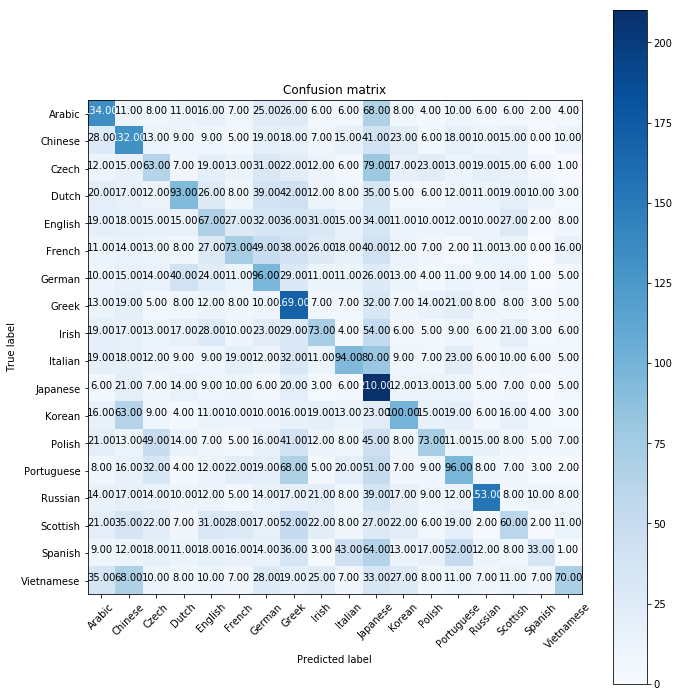

In [71]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

# Scratch

In [46]:
aa = ['an', 'catto', 'nicky', 'Tom']
sorted(aa, reverse=True, key=len)

['catto', 'nicky', 'Tom', 'an']

In [50]:
bb = ['mad', 'max']

In [51]:
bb[2:]

[]

In [52]:
bb[:2]

['mad', 'max']

In [47]:
aa

['an', 'catto', 'nicky', 'Tom']

In [48]:
aa[2:]

['nicky', 'Tom']

In [49]:
aa[:2]

['an', 'catto']